In [1]:
import numpy as np
import pandas as pd
import tables as tb

import invisible_cities.reco.peak_functions as rp
from invisible_cities.database import load_db

import matplotlib.pyplot as plt

import invisible_cities.reco.calib_sensors_functions as csf
from invisible_cities.types.ic_types import minmax
from invisible_cities.evm.pmaps import S1, S2

In [2]:
# Plotting style
default_cmap = "viridis"
figure_size  = 12, 4
font_size    = 14

plt.rcParams["figure.figsize"]  = figure_size
plt.rcParams[  "font.size"   ]  = font_size
plt.rcParams[  "image.cmap"  ]  = default_cmap
plt.rcParams["axes.facecolor"]  = 'ghostwhite'
plt.rcParams["axes.grid"     ]  = True
plt.rcParams["grid.color"    ]  = 'lightgrey'
plt.rcParams["axes.formatter.limits"] = -4, 4
plt.rcParams["font.family"]='serif'

#plt.style.use(plt.style.available[10])

In [3]:
def calibratedwf(wf):
    '''Given a CWF (for all PMT), it returns the total calibrated wf'''
    adc_to_pes = load_db.DataPMT(run).adc_to_pes.values
    calwf = csf.calibrate_wfs(wf, adc_to_pes)
#     calwf = calwfs.sum(axis=0)
    return calwf


def s1finder(wf):
    
    adc_to_pes = load_db.DataPMT(run).adc_to_pes.values
    calwf = csf.calibrate_wfs(wf, adc_to_pes)
    wf = calwf.sum(axis=0)
    
    rms = 0.5
    index = np.argwhere(wf>rms).flatten()
    
    time = minmax(0, 640)*1000
    length = minmax(4, 40)
    stride = 4
    rebin_stride = 1

    pmt_ids = np.arange(12)
    Pk = S1
    
    ccwfs = calwf
    res = rp.find_peaks(ccwfs, index,
                   time, length,
                   stride, rebin_stride,
                   Pk, pmt_ids,
                   sipm_wfs=None, thr_sipm_s2=0)
    return res


def s2finder(wf):

    adc_to_pes = load_db.DataPMT(run).adc_to_pes.values
    calwf = csf.calibrate_wfs(wf, adc_to_pes)
    wf = calwf.sum(axis=0)
    
    rms = 0.5
    index = np.argwhere(wf>rms).flatten()
    
    time = minmax(640, 1300)*1000
    length = minmax(500, 1e4)
    stride = 40
    rebin_stride = 1

    pmt_ids = np.arange(12)
    Pk = S2
    
    ccwfs = calwf
    res = rp.find_peaks(ccwfs, index,
                   time, length,
                   stride, rebin_stride,
                   Pk, pmt_ids,
                   sipm_wfs=None, thr_sipm_s2=0)
    return res

# IMPORT WFS AND EVENT SUMMARY

In [4]:
#wfs
peak = 'Tl_photopeak'
wfdir  = f'./DATA/'
wffilename = f'selected_cwf_{peak}_000.h5'
file = tb.open_file(wfdir+wffilename)
wfs_by_event = file.root.BLR.pmtcwf


#evtsum
run =6482
directory = '../DATA/'
filename  = f'cepks_{run}_0000_11999_6q0min.h5'
data = pd.HDFStore(directory + filename)['/esum']


#thds
evts = np.array([x['evt_number'] for x in file.root.Run.events.iterrows()])
thds = data[np.in1d(data.event.values, evts)]

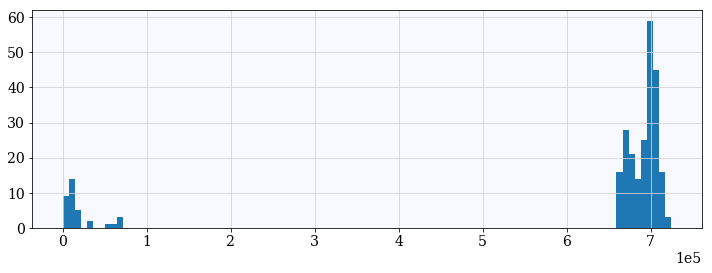

In [5]:
thds['e'].hist(bins=100);

# SINGLE EVENT WF STUDY

In [159]:
i=int(np.random.random()*len(wfs_by_event))
wfs = wfs_by_event[i]
calwfs = calibratedwf(wfs)

print()
print(f'Event to study: {evts[i]}')
print()


Event to study: 1276672



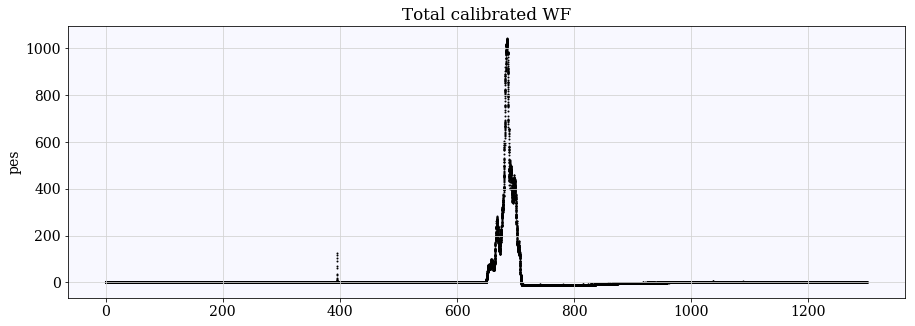

In [160]:
t = np.arange(len(wfs.sum(axis=0)))/40

fig = plt.figure(figsize=[15, 5])

ax = fig.add_subplot(111)
ax.set_title('Total calibrated WF')
ax.scatter(t, calwfs.sum(axis=0), c='black', s=1)
ax.set_ylabel('pes');

### Searching S1 and S2

In [161]:
s1 = s1finder(wfs)[0]
s2 = s2finder(wfs)[0]

s1tim = s1.times/1000
s2tim = s2.times/1000

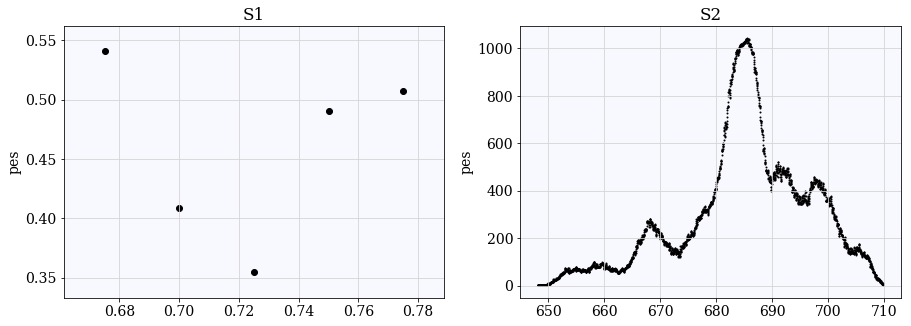

In [162]:
t = np.arange(len(wfs.sum(axis=0)))/40

fig = plt.figure(figsize=[15, 5])

ax = fig.add_subplot(121)
ax.set_title('S1')
idx = np.argwhere((s1tim[0]<=t)&(t<=s1tim[-1])).flatten()
ax.scatter(t[idx], calwfs.sum(axis=0)[idx], c='black')
ax.set_ylabel('pes')

ax = fig.add_subplot(122)
ax.set_title('S2')
idx = np.argwhere((s2tim[0]<=t)&(t<=s2tim[-1])).flatten()
ax.scatter(t[idx], calwfs.sum(axis=0)[idx], c='black', s=1)
ax.set_ylabel('pes');

## Comparing PMT WFs

In [163]:
pmt1, pmt2 = 0, 11 #pmts to compare

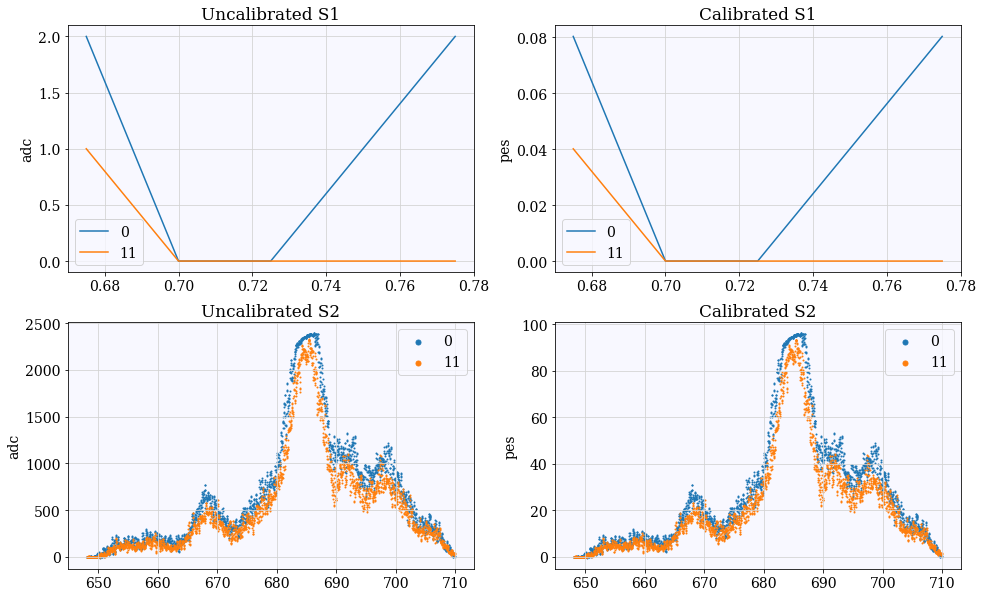

In [164]:
t = np.arange(len(wfs.sum(axis=0)))/40

fig = plt.figure(figsize=[16, 10])

#S1
idx = np.argwhere((s1tim[0]<=t)&(t<=s1tim[-1])).flatten()
ax = fig.add_subplot(221)
ax.set_title('Uncalibrated S1')
ax.plot(t[idx], wfs[pmt1][idx], label=pmt1)
ax.plot(t[idx], wfs[pmt2][idx], label=pmt2)
ax.set_ylabel('adc')
ax.legend();

ax = fig.add_subplot(222)
ax.set_title('Calibrated S1')
ax.plot(t[idx], calwfs[pmt1][idx], label=pmt1)
ax.plot(t[idx], calwfs[pmt2][idx], label=pmt2)
ax.set_ylabel('pes')
ax.legend();

#S2
idx = np.argwhere((s2tim[0]<=t)&(t<=s2tim[-1])).flatten()
ax = fig.add_subplot(223)
ax.set_title('Uncalibrated S2')
ax.scatter(t[idx], wfs[pmt1][idx], s=1, label=pmt1)
ax.scatter(t[idx], wfs[pmt2][idx], s=1, label=pmt2)
ax.set_ylabel('adc')
ax.legend(markerscale=5);

ax = fig.add_subplot(224)
ax.set_title('Calibrated S2')
ax.scatter(t[idx], calwfs[pmt1][idx], s=1, label=pmt1)
ax.scatter(t[idx], calwfs[pmt2][idx], s=1, label=pmt2)
ax.set_ylabel('pes')
ax.legend(markerscale=5);

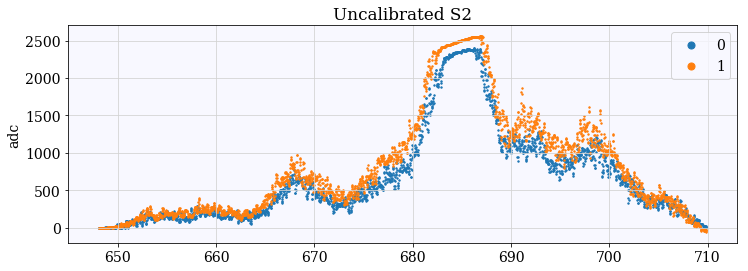

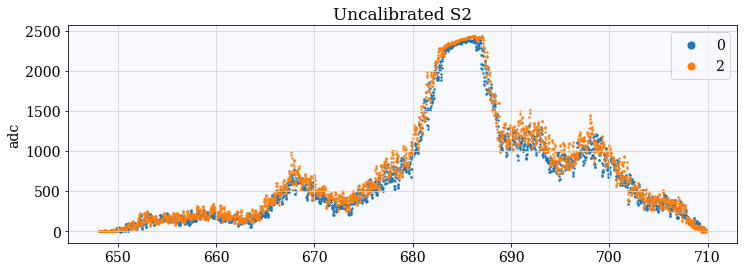

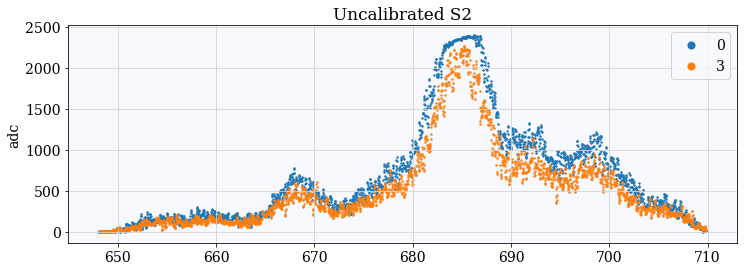

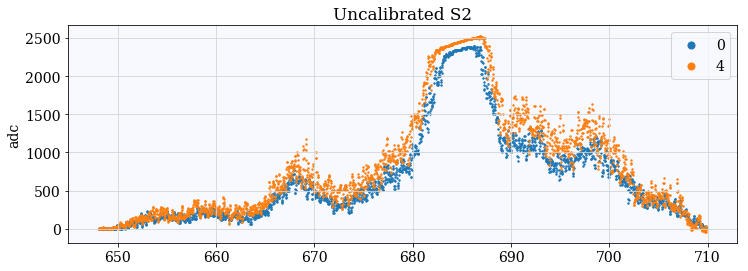

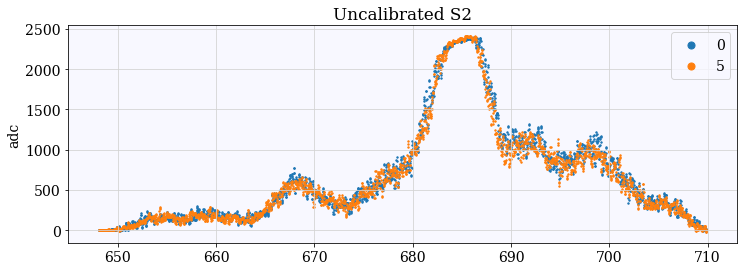

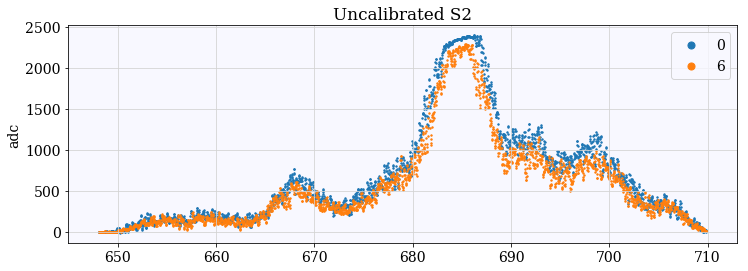

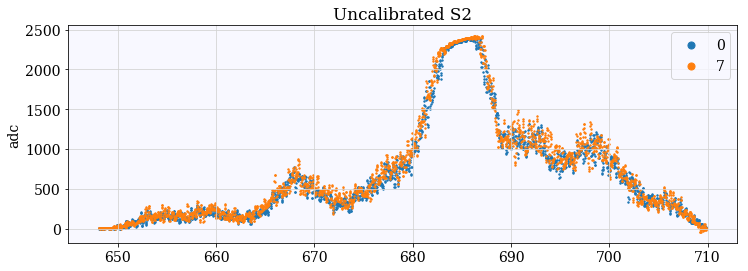

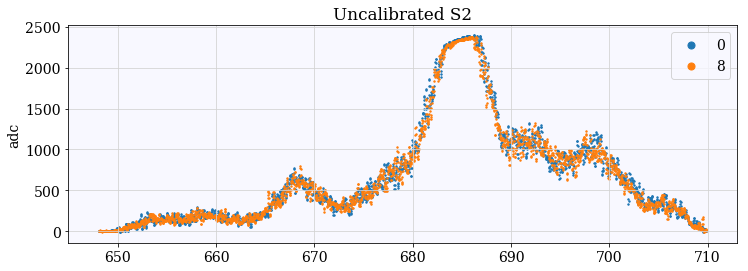

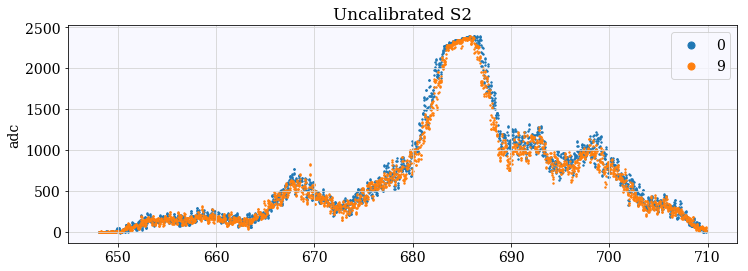

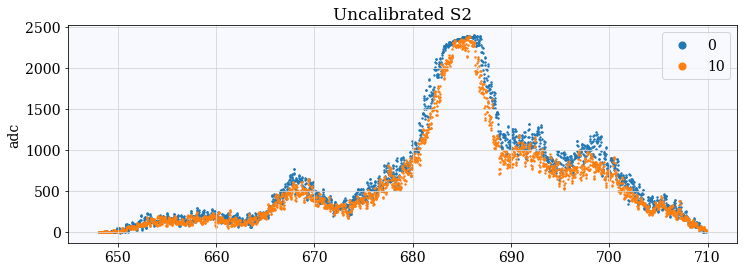

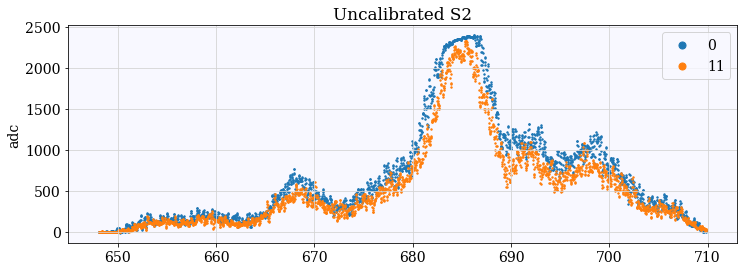

In [165]:
pmt1 = 0
pmt2s = np.arange(1, 12)

for pmt2 in pmt2s:
    fig = plt.figure(figsize=[12, 4])
    ax = fig.add_subplot(111)
    ax.set_title('Uncalibrated S2')
    ax.scatter(t[idx], wfs[pmt1][idx], s=2, label=pmt1)
    ax.scatter(t[idx], wfs[pmt2][idx], s=2, label=pmt2)
    ax.set_ylabel('adc')
    ax.legend(markerscale=5);

### Checking peak_finder energies

In [1]:
#S1 Energy

t = np.arange(len(wfs.sum(axis=0)))/40
idx = np.argwhere((s1tim[0]<=t)&(t<=s1tim[-1])).flatten()

print()
print(f'Calculated S1 energy:{calwfs[:, idx].sum()} pes')
print()
print(f'S1 finder energy:{s1.total_energy} pes')

NameError: name 'np' is not defined

In [15]:
#S2 Energy

t = np.arange(len(wfs.sum(axis=0)))/40
idx = np.argwhere((s2tim[0]<=t)&(t<=s2tim[-1])).flatten()

#sum over positive energies
calwfs_S2 = calwfs[:, idx]
calwf_S2 = calwfs_S2.sum(axis=0)
idx1 = calwf_S2>0

print()
print(f'Calculated S2 energy:{calwf_S2[idx1].sum()} pes')
print()
print(f'S2 finder energy:{s2.total_energy} pes')


Calculated S2 energy:356972.05529855425 pes

S2 finder energy:356972.05529855425 pes


## PMAP CHECK

In [16]:
ev = evts[i]
print()
print(f'Event to study: {ev}')
print()
evt_sum = thds[thds.event==ev]
loc = evt_sum.location.values[0]
loc = '{:04}'.format(loc)
print(f'pmap location:{loc}')


Event to study: 2357764

pmap location:6686


In [17]:
if int(loc)<=9999: 
    filen = f'/home/gonzalo/Documentos/NEXT/DATA/{run}/pmaps_{loc}_{run}_trigger2_v0.9.9_20181011_krth1300.h5'
    pmaps = pd.HDFStore(filen)
    print(filen)
else:
    print('No pmap')

/home/gonzalo/Documentos/NEXT/DATA/6482/pmaps_6686_6482_trigger2_v0.9.9_20181011_krth1300.h5


In [18]:
s1p, s1pmt, s2p, s2pmt = pmaps['/PMAPS/S1'], pmaps['/PMAPS/S1Pmt'] , pmaps['/PMAPS/S2'], pmaps['/PMAPS/S2Pmt']
s1p, s1pmt, s2p, s2pmt = s1p[s1p.event==ev], s1pmt[s1pmt.event==ev], s2p[s2p.event==ev], s2pmt[s2pmt.event==ev]

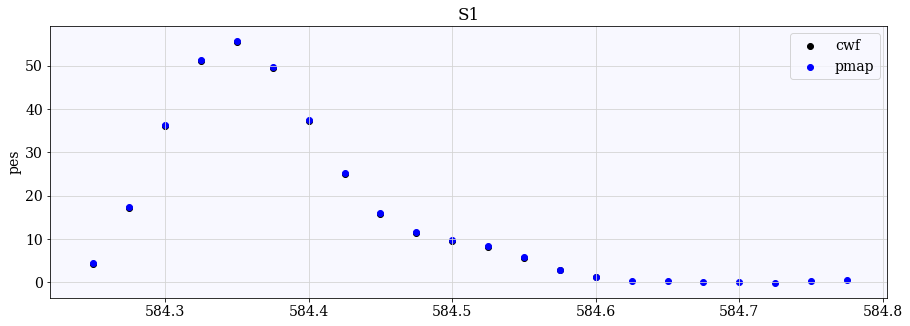

In [19]:
#S1 waveforms
t = np.arange(len(wfs.sum(axis=0)))/40
idx = np.argwhere((s1tim[0]<=t)&(t<=s1tim[-1])).flatten()

fig = plt.figure(figsize=[15, 5])

ax = fig.add_subplot(111)
ax.set_title('S1')
ax.scatter(t[idx]   , calwfs.sum(axis=0)[idx], label='cwf'    ,c='black')
ax.scatter(s1p.time*1e-3, s1p.ene            , label='pmap'   , c='blue');
ax.set_ylabel('pes')
ax.legend();

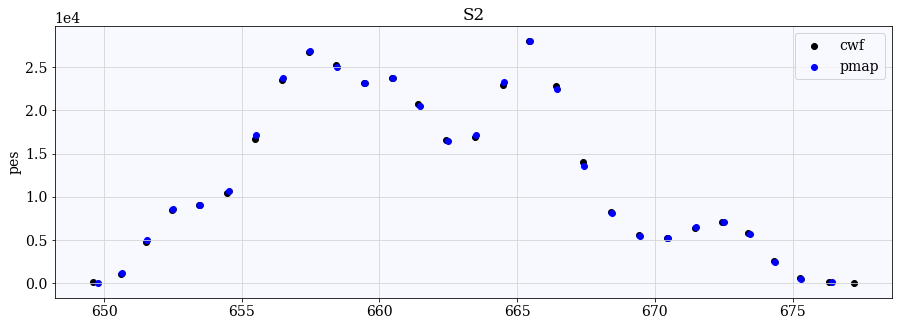

In [20]:
#S2 waveforms
t = np.arange(len(wfs.sum(axis=0)))/40
idx = np.argwhere((s2tim[0]<=t)&(t<=s2tim[-1])).flatten()

fig = plt.figure(figsize=[15, 5])
ax = fig.add_subplot(111)
ax.set_title('S2')

times, waveforms, rebin_stride = t[idx], calwfs[:, idx], 40
rebinned_times, rebinned_wfs = rp.rebin_times_and_waveforms(times, waveforms, rebin_stride)
plt.scatter(rebinned_times, rebinned_wfs.sum(axis=0), label='cwf' , c='black')

ax.scatter(s2p.time*1e-3  , s2p.ene                 , label='pmap' , c='blue');
ax.set_ylabel('pes');
ax.legend();

# RECOMBINATION STUDIES

In [21]:
#Recombination energy

re1 = []
re2 = []
re3 = []

for i in range(0, len(evts)):
    wf = wfs[i]

    calwf = calibratedwf(wf)
    
    #peak finder
    try:
        s1 = s1finder(wf)[0]
        s2 = s2finder(wf)[0]
    except IndexError: 
        re1.append(-1)
        re2.append(-1)
        re3.append(-1)
        continue
    
    #energy
    t = np.linspace(0, len(calwf), len(calwf))/40*1000
    

    idx = np.argwhere((s1.times[-1]<=t)&(t<=s2.times[0])).flatten()
    re2.append(calwf[idx].sum()/(s2.times[0]-s1.times[-1]))
    
    idx = np.argwhere(t<=s1.times[0]).flatten()
    re1.append(calwf[idx].sum()/s1.times[0])
    
    idx = np.argwhere(s2.times[-1]<=t).flatten()
    re3.append(calwf[idx].sum()/(t[-1]-s2.times[-1]))
    
    
    print(f'Proccessed {i}/{len(evts)}', end='\r')

ValueError: non-broadcastable output operand with shape (52000,) doesn't match the broadcast shape (12,52000)

In [ ]:
re1=np.array(re1)
re2=np.array(re2)
re3=np.array(re3)

In [ ]:
np.argwhere(re1==re1.max()).flatten()

In [ ]:
re1 = np.delete(re1, np.argwhere(re1==re1.max()).flatten()[0])
re2 = np.delete(re2, np.argwhere(re1==re1.max()).flatten()[0])
re3 = np.delete(re3, np.argwhere(re1==re1.max()).flatten()[0])

In [ ]:
rg = (0, 0.003)
plt.hist(re1, bins=100, alpha=0.4, label='1', density=True, range=rg);
plt.hist(re2, bins=100, alpha=0.4, label='2', density=True, range=rg);
plt.hist(re3, bins=100, alpha=0.4, label='3', density=True, range=rg);

plt.legend();

In [ ]:
re1=np.array(re1)
re2=np.array(re2)
re3=np.array(re3)

In [ ]:
rg = ((30, 70), (0, 50))

plt.hist2d(thds.zsize[thds.peak==0], re3, range=rg, bins=30);
plt.xlabel('z-size (mm)');
plt.ylabel('Recom Energy (pes)');

In [ ]:
np.argwhere(RE==0).flatten()

In [ ]:
rg = ((0, 100), (thds.s1e.mean()-thds.s1e.std(), thds.s1e.mean()+thds.s1e.std()))
      
plt.hist2d(thds.zsize[thds.peak==0], thds.s1e[thds.peak==0], bins=50, range=rg);

In [ ]:
wf = wfs[3]

adc_to_pes = load_db.DataPMT(run).adc_to_pes.values
calwf = csf.calibrate_wfs(wf, adc_to_pes)
wf = calwf.sum(axis=0)

rms = 0.5 
index = np.argwhere(wf>rms).flatten()

In [ ]:
time = minmax(0, 640)*1000
length = minmax(4, 15)
stride = 4
rebin_stride = 1

pmt_ids = np.arange(12)
Pk = S1

In [ ]:
ccwfs = calwf

rp.find_peaks(ccwfs, index,
               time, length,
               stride, rebin_stride,
               Pk, pmt_ids,
               sipm_wfs=None, thr_sipm_s2=0)